Music Generator with LSTM



---









In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev
!pip install -q 'tensorflow-datasets < 4.0.0'
!pip install -qU google-cloud magenta pyfluidsynth

import glob
import pickle
import numpy
import note_seq
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/content/drive')

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 3.4MB 16.2MB/s 
     |████████████████████████████████| 1.4MB 14.6MB/s 
     |████████████████████████████████| 5.6MB 25.6MB/s 
     |████████████████████████████████| 92kB 12.9MB/s 
     |████████████████████████████████| 215kB 60.4MB/s 
     |████████████████████████████████| 204kB 62.1MB/s 
     |████████████████████████████████| 358kB 52.9MB/s 
     |████████████████████████████████| 2.3MB 56.3MB/s 
     |████████████████████████████████| 1.5MB 44.8MB/s 
     |████████████████████████████████| 71k

1. Using music21 to read .MID files

In [ ]:
notes = []
for file in glob.glob("/content/drive/My Drive/Fall '20/CMPE 188/Project/audio/train/*.mid"):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

In [ ]:
print(len(set(notes)))

232



2. Creating sequence out of music 21 stream by mapping the string data into numerical data

In [ ]:
n_vocab = len(set(notes))
sequence_length = 100
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)

3. Create Model

In [ ]:
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(156))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

4. Model Training

In [ ]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
history = model.fit(network_input, network_output, epochs=200, batch_size=64, callbacks=callbacks_list)

271/293 [==========================>...] - ETA: 1s - loss: 4.2865

KeyboardInterrupt: ignored

In [ ]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 512)          2099200   
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 512)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

In [ ]:
# Load the weights to each node
model.load_weights('/content/weights-improvement-185-0.0184-bigger.hdf5')

In [ ]:
start = numpy.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
# generate 200 notes
for note_index in range(200):
    prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern = numpy.append(pattern, index)
    pattern = pattern[1:len(pattern)]

In [ ]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [ ]:
from music21 import instrument, note, stream, chord
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'

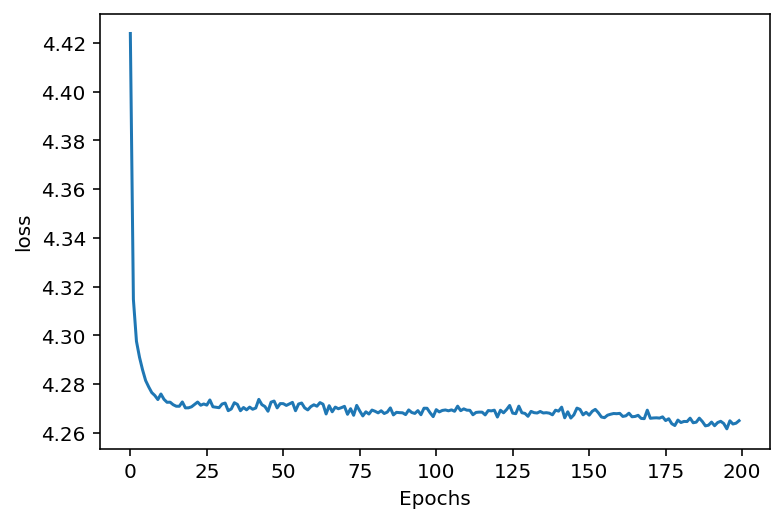

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'loss')

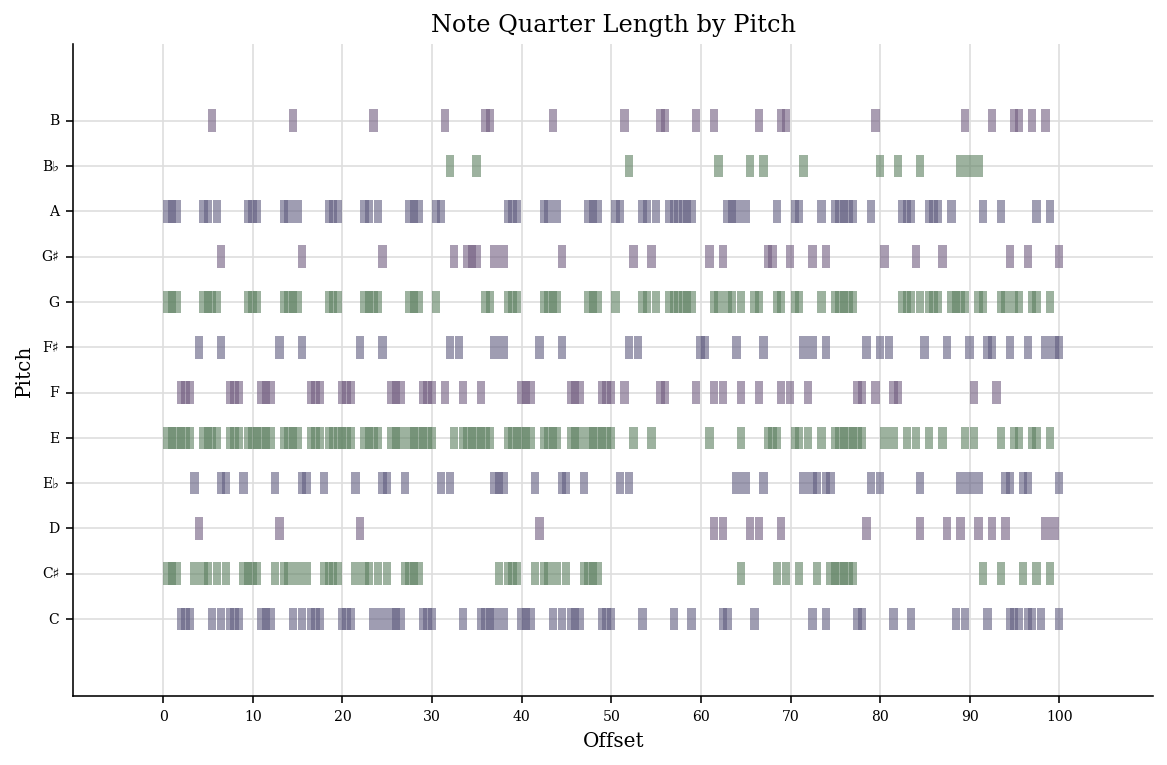

In [ ]:
midi_stream.plot('pianoroll')